* CNN 과 RNN 결합
* 새로운 레이어 instance화
* CTC 손실 구현 ( 엔드포인트 레이어 )
    - CTC( Connectionist Temporal Classification ): 입력 시퀸스와 타겟 시퀸스 간에 명시적인 alignment 정보 없이 학습
    - RNN은 Sequence 데이터를 학습을 잘하지만 Segmentation 이 되어있지 않으면 학습이 힘듦 -> Unsegmentation 된 데이터를 학습하기 위해 CTC Loss를 사용

# 준비

In [1]:
import os
import shutil
import zipfile
import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 데이터 로드

In [2]:
# 다운로드
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
print("다운로드 완료")

# 파일 이동
shutil.move("captcha_images_v2.zip", "D:Dataset/dataset/Kaggle/")
print("파일 이동 완료")

# 압축해제
with zipfile.ZipFile("D:Dataset/dataset/Kaggle/captcha_images_v2.zip","r") as zip_ref:
    zip_ref.extractall("D:Dataset/dataset/Kaggle/")
print("압축 해제 완료")

# 압축파일 제거
os.remove("D:Dataset/dataset/Kaggle/captcha_images_v2.zip")
print("압축파일 제거 완료")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

 33 8863k   33 2992k    0     0  2263k      0  0:00:03  0:00:01  0:00:02 2263k
100 8863k  100 8863k    0     0  4673k      0  0:00:01  0:00:01 --:--:--  9.9M


다운로드 완료
파일 이동 완료
압축 해제 완료
압축파일 제거 완료


In [3]:
# 파일 path
data_dir = Path("D:Dataset/dataset/Kaggle/captcha_images_v2/")

# img_path, label 값 분리
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# 설정
batch_size = 16
img_width = 200
img_height = 50

# 2개의 conv 블록
# 각 블록당 2개의 다운샘플링
# 총 4
downsample_factor = 4

# 가장 긴 image_length
max_length = max([len(label) for label in labels])

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


## 전처리

In [4]:
# 문자에 숫자 label 할당
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)

# 숫자 label 을 character로 변환
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

# TTS
def split_data(images, labels, train_size=0.9, shuffle=True):
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    train_samples = int(size * train_size)
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # image preprocess
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2]) # height <-> width
    
    # label preprocess
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    
    return {"image": img, "label": label}

## 데이터 셋

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(batch_size)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## 데이터 확인

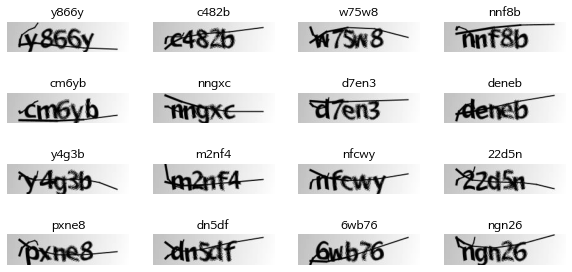

In [6]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

# 모델

In [7]:
# CTC Loss check layer instance
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
        
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred


def build_model():
    # input : img , label
    input_img = layers.Input(shape=(img_width, img_height, 1), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # Conv block 1 -> downsampling (1/2)
    x = layers.Conv2D(32, (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Conv block 2 -> downsampling (1/2)
    x = layers.Conv2D(64, (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # x reshape
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    
    # Dense
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2" )(x)

    # CTC loss layer
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="ocr_model_v1")
    
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt)
    return model

In [8]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

# 훈련

In [9]:
epochs = 100
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[es],
)

Epoch 1/100
59/59 [==============================] - 11s 48ms/step - loss: 20.2317 - val_loss: 16.4290
Epoch 2/100
59/59 [==============================] - 2s 25ms/step - loss: 16.3633 - val_loss: 16.4142
Epoch 3/100
59/59 [==============================] - 2s 25ms/step - loss: 16.3470 - val_loss: 16.4194
Epoch 4/100
59/59 [==============================] - 1s 25ms/step - loss: 16.3446 - val_loss: 16.4280
Epoch 5/100
59/59 [==============================] - 1s 25ms/step - loss: 16.3337 - val_loss: 16.4408
Epoch 6/100
59/59 [==============================] - 1s 25ms/step - loss: 16.3281 - val_loss: 16.4628
Epoch 7/100
59/59 [==============================] - 1s 25ms/step - loss: 16.3211 - val_loss: 16.4608
Epoch 8/100
59/59 [==============================] - 2s 26ms/step - loss: 16.3055 - val_loss: 16.4568
Epoch 9/100
59/59 [==============================] - 2s 26ms/step - loss: 16.2678 - val_loss: 16.4426
Epoch 10/100
59/59 [==============================] - 1s 25ms/step - loss: 16.148

# predict

In [10]:
prediction_model = tf.keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)
prediction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

1/1 [==============================] - 1s 967ms/step


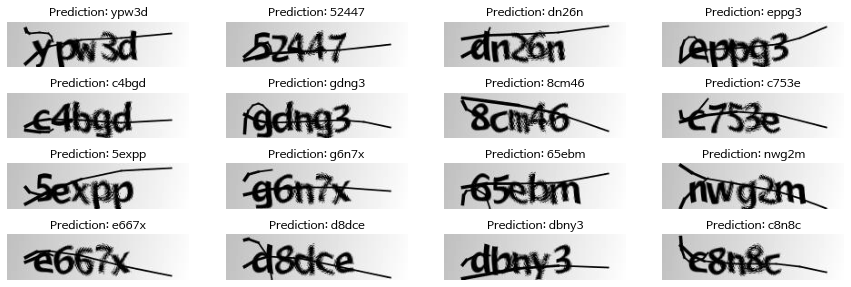

In [11]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()